In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import os
import zipfile

In [17]:
def unzip_samples(file = "data.zip", overwrite = False):
    if not os.path.exists(os.path.splitext(file)[0]) or overwrite:
        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall(".")

def generate_datasets(zip_data_path = "data.zip", train_set_path = "train_set", test_set_path = "test_set", validation_set_path = "validation_set"):
    unzip_samples(zip_data_path)
    generate_tensors(train_set_path, sample_start = 1, sample_end = 200)
    generate_tensors(test_set_path, sample_start = 201, sample_end = 250)
    generate_tensors(validation_set_path, sample_start = 251, sample_end = 300)

def sample_path(class_name, sample, channel):
    png_path = "data/" + class_name + "/dat_ch" + str(channel) + "_" + str(sample) + ".png"
    return png_path

def show_sample(class_name, sample):
    print("Sample = {}, class = {}".format(sample, class_name))
    fig, ax = plt.subplots(1, 4)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    for i in range(4):
        im = Image.open(sample_path(class_name = class_name, sample = sample, channel = i+1), "r")
        ax[i].set_title("Ch {}".format(i+1))
        ax[i].imshow(im)
    fig.show()

def show_grid(sample, channels = 4):
    print("Grid (sample = {}, channels = {})".format(sample, channels))
    fig, ax = plt.subplots(4, 4)
    fig.set_figwidth(10)
    fig.set_figheight(12)
    matrix = np.zeros((32, 32, channels), dtype="uint8")
    for row in range(4):
        for col in range(4):
            class_name = "A" + str(row + 1) + str(col + 1)
            for ch in range(channels):
                matrix[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r"))
            ax[row, col].set_title(class_name)
            ax[row, col].imshow(matrix)
    plt.show()

def generate_sample_tensor(class_name = "A11", sample = 1, channels = 4):
    tensor = np.zeros((32, 32, channels), dtype="uint8")
    for ch in range(channels):
        tensor[:, :, ch] = np.array(Image.open(sample_path(class_name = class_name, sample = sample, channel = ch + 1), "r"))
    return tensor

def generate_tensors(dest_path = "tensors", sample_start = 1, sample_end = 300, overwrite = False):
    if not os.path.exists(dest_path) or overwrite:
        for row in range(4):
            for col in range(4):
                class_name = "A" + str(row + 1) + str(col + 1)
                path = os.path.join(dest_path, class_name)
                if not os.path.exists(path):
                    os.makedirs(path)
                for i in range(sample_start, sample_end + 1):
                    file_name = os.path.join(path, "data_" + str(i))
                    tensor = generate_sample_tensor(class_name = class_name, sample = i)
                    np.save(file_name, tensor)

def create_labeled_data(srs_path = "tensors"):
    labeled_data = []
    categories = os.listdir(srs_path)
    categories.sort()
    for category in categories:
        path = os.path.join(srs_path, category)  # create path to the classes
        class_num = categories.index(category)  # get the classification  0 = A11, 1 = A12, 2 = A13, ...etc

        file_list = os.listdir(path)
        file_list.sort()
        for file in file_list:
            file = os.path.join(path, file)
            sample = np.load(file)
            labeled_data.append([sample, class_num])
    
    random.shuffle(labeled_data)

    X = []
    Y = []
    for sample, label in labeled_data:
        X.append(sample)
        Y.append(label)

    X = np.array(X)
    X = X.astype("float32")/255

    Y = np.array(Y)
    np.reshape(Y, (len(Y), 1))
    Y = to_categorical(Y)
    return X, Y

def get_category(distributions, max_row = 4, max_col = 4):
    category_index = distributions.argmax()

    col = category_index % max_col
    row = int((category_index - col) / max_row)
    category = "A" + str(row + 1) + str(col + 1)
    return category

# plot diagnostic learning curves
def summarize_diagnostics(history, filename):
    # plot loss
    f = pyplot.figure()
    f.set_figwidth(10)
    f.set_figheight(20)

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    pyplot.savefig(filename + '.png')
    pyplot.close()

In [3]:
def define_model():
    model = Sequential()

    model.add(Conv2D(40, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(60, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(120, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(16, activation='softmax'))
    # compile model
    #opt = SGD(learning_rate=0.001, momentum=0.9)
    opt = "adam"
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
zip_data_path = "data.zip"
train_set_path = "train_set"
test_set_path = "test_set"
validation_set_path = "validation_set"

generate_datasets (zip_data_path, train_set_path, test_set_path, validation_set_path)

In [5]:

train_X, train_Y = create_labeled_data(srs_path = train_set_path)
test_X, test_Y = create_labeled_data(srs_path = test_set_path)
val_X, val_Y = create_labeled_data(srs_path = validation_set_path)


In [6]:
model_file_name = "model.h5" # Set the file name for the model

model = define_model()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(train_X, train_Y, epochs=100, batch_size=10, validation_data=(test_X, test_Y), verbose=1, callbacks=[monitor])

_, val_acc = model.evaluate(val_X, val_Y, verbose=1)

print("Validation accuracy > {:.2f}".format(val_acc * 100.0))
print("Saving model > {}".format(model_file_name))

model.save(model_file_name)
summarize_diagnostics(history, "optimization")

print("Done!")

2021-12-05 19:32:09.514916: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-05 19:32:09.521333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 19:32:09.522217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 860M computeCapability: 5.0
coreClock: 1.0195GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2021-12-05 19:32:09.522431: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-12-05 19:32:09.523569: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libc

Epoch 1/100
320/320 [==============================] - 9s 29ms/step - loss: 0.7117 - accuracy: 0.8206 - val_loss: 0.4291 - val_accuracy: 0.8512
Epoch 2/100
320/320 [==============================] - 9s 28ms/step - loss: 0.0532 - accuracy: 0.9822 - val_loss: 0.1030 - val_accuracy: 0.9600
Epoch 3/100
320/320 [==============================] - 10s 31ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.1697 - val_accuracy: 0.9362
Epoch 4/100
320/320 [==============================] - 9s 29ms/step - loss: 0.0172 - accuracy: 0.9966 - val_loss: 0.0771 - val_accuracy: 0.9700
Epoch 5/100
320/320 [==============================] - 10s 30ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.1685 - val_accuracy: 0.9337
Epoch 6/100
320/320 [==============================] - 9s 29ms/step - loss: 0.0201 - accuracy: 0.9934 - val_loss: 0.0505 - val_accuracy: 0.9837
Epoch 7/100
320/320 [==============================] - 9s 28ms/step - loss: 0.0581 - accuracy: 0.9847 - val_loss: 0.4767 - val_accurac

In [11]:
file = validation_set_path + "/A21/data_280.npy"
sample = np.load(file)
sample = sample.astype('float32') / 255.0
sample = np.expand_dims(sample, axis=0)

model = load_model(model_file_name)

model_output = model.predict(sample)

print("Input sample = {}, model prediction = {}".format(file, get_category(model_output)))

Input sample = validation_set/A21/data_280.npy, model prediction = A21


Grid (sample = 280, channels = 4)


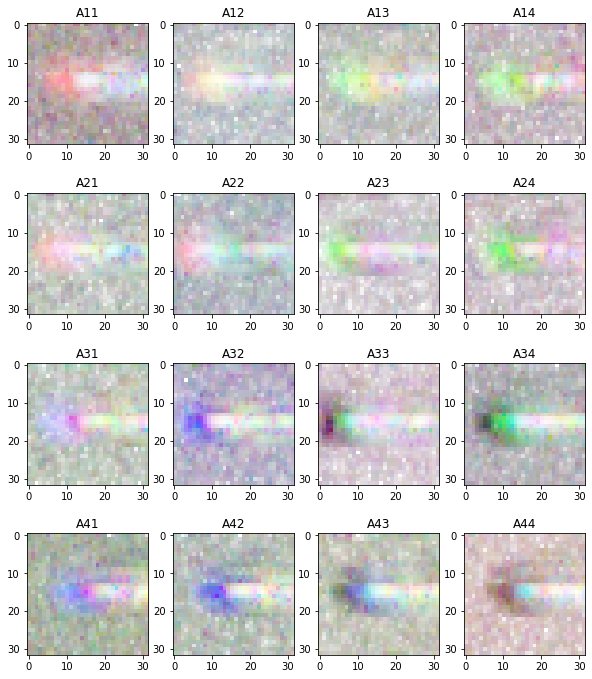

In [8]:
show_grid(sample = 280)

Sample = 280, class = A21


/tmp/ipykernel_28810/1434090847.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


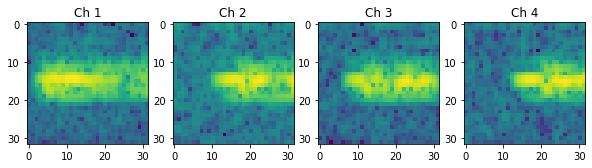

In [9]:
show_sample(class_name = "A21", sample = 280)